# Defacing pre-registration - Statistical analysis on manual ratings in R

## Load simulated manual ratings

In [16]:
df_full <- readRDS(file="SimulatedData/SimulatedDefacedRatings_noMissing.Rda")
df_missing <- readRDS(file="SimulatedData/SimulatedDefacedRatings_10%Missing.Rda")

df_4 <- subset(df_full, rater == sprintf('rater%02d', 3:7))

#Define the number of raters in the dataset
n_rater = length(unique(df_full$rater))

The simulated data were generated by running the `SimulateDefacedRatings.ipnyb` notebook.

## Linear mixed effect regression

Because the continuation ratio model implementation could not deal with missing values, we are switching to linear mixed effect regression model. It has been shown that considering linear regression on ordinal data is ok, as long as the probabilities of belonging to each category are far from the extremes.

In [17]:
library(lme4)
fm1 <- lmer(as.numeric(ratings) ~ defaced + (defaced | rater), data=df_4)
summary(fm1)
ranef(fm1)

boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: as.numeric(ratings) ~ defaced + (defaced | rater)
   Data: df_4

REML criterion at convergence: 3522.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7496 -0.7932  0.1161  1.0112  1.3790 

Random effects:
 Groups   Name           Variance  Std.Dev. Corr
 rater    (Intercept)    0.0002419 0.01555      
          defaceddefaced 0.0076473 0.08745  1.00
 Residual                1.2095689 1.09980      
Number of obs: 1160, groups:  rater, 5

Fixed effects:
               Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)     2.49655    0.04619 73.46889   54.05  < 2e-16 ***
defaceddefaced  0.34655    0.07550  7.05520    4.59  0.00246 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
defaceddfcd -0.520
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see ?isSingular


$rater
         (Intercept) defaceddefaced
rater04 -0.013142377    -0.07389481
rater05  0.006757203     0.03799330
rater06 -0.010276333    -0.05778009
rater07  0.004418143     0.02484161
rater08  0.012243363     0.06883999

with conditional variances for “rater” 

In [18]:
fm2 <- lmer(as.numeric(ratings) ~ defaced*rater + (1 | rater), data=df_4)
summary(fm2)
ranef(fm2)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“ Hessian is numerically singular: parameters are not uniquely determined”


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: as.numeric(ratings) ~ defaced * rater + (1 | rater)
   Data: df_4

REML criterion at convergence: 3532.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.81613 -0.82196  0.08611  0.97069  1.44038 

Random effects:
 Groups   Name        Variance Std.Dev.
 rater    (Intercept) 0.005765 0.07593 
 Residual             1.212736 1.10124 
Number of obs: 1160, groups:  rater, 5

Fixed effects:
                              Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)                  2.414e+00  1.274e-01  9.676e-09  18.953   1.0000  
defaceddefaced               2.672e-01  1.446e-01  1.150e+03   1.848   0.0648 .
raterrater05                 9.483e-02  1.801e-01  9.676e-09   0.527   1.0000  
raterrater06                 1.379e-01  1.801e-01  9.676e-09   0.766   1.0000  
raterrater07                 6.034e-02  1.801e-01  9.676e-09   0.335   1.0000  
raterrater08    

$rater
          (Intercept)
rater04 -1.097955e-14
rater05 -7.263393e-15
rater06 -8.276890e-15
rater07 -7.939058e-15
rater08 -8.952555e-15

with conditional variances for “rater” 

### Visualize fixed effect regression coefficients

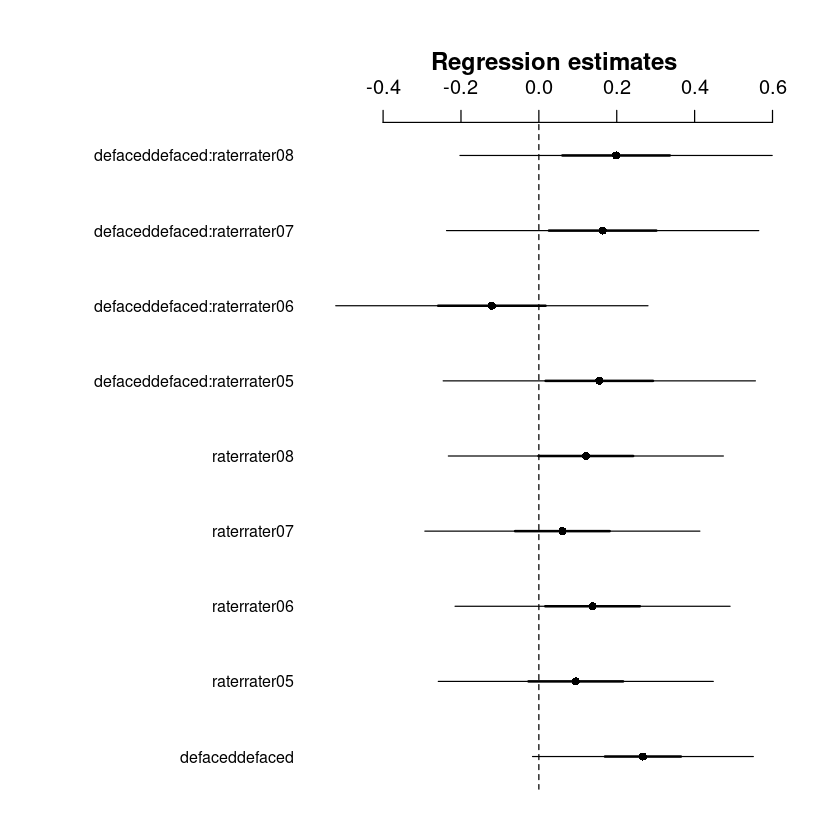

In [27]:
library(coefplot2)
coefplot2(fm2)

The thick bars correspond to ±1SD or 50% credible intervals and the thin lines to ±2SD or 95% CI

### Visualize random effects

We extract the regression coefficients and overlay the resulting regression lines on the data to get a sense of the data fit

In [64]:
# see group coefficients
# see group coefficients
model_coefs <- coef(fm1)$rater %>%
  rename(Intercept = `(Intercept)`, Slope = defaceddefaced) %>% 
  rownames_to_column("rater")

# see coefficients
model_coefs

rater,Intercept,Slope
<chr>,<dbl>,<dbl>
rater04,2.483409,0.2726569
rater05,2.503309,0.3845450
rater06,2.486275,0.2887716
rater07,2.500970,0.3713933
rater08,2.508795,0.4153917


First, we’ll join these coefficients to our original data so we can plot the individual lines.

In [65]:
library(tidyverse)
fm1_groups <- left_join(df_4, model_coefs, by = "rater")

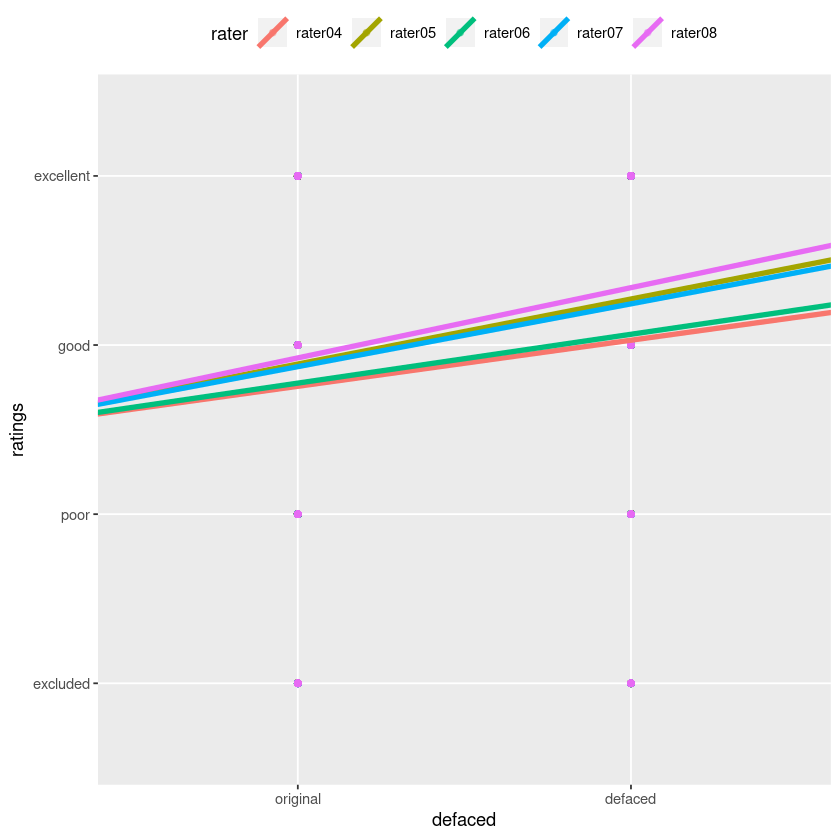

In [66]:
library(ggplot2)
model_coef_plot <- ggplot(data = fm1_groups, 
       mapping = aes(x = defaced, 
                     y = ratings, 
                     colour = rater)
       ) +
  geom_point(na.rm = T, alpha = 0.5) +
  geom_abline(aes(intercept = Intercept, 
                  slope = Slope,
                  colour = rater
                  ),
              size = 1.5
              ) +
  theme(legend.position = "top")

# see the plot
model_coef_plot

### Which formula ?

I am not sure whether we should include the interaction between defaced and rater as an interaction term in the fixed effect or as a random slope in the random effects.
Therefore I'm running an log likelihood ratio test to compare both models.

In [4]:
anova(fm1, fm2)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm1,6,41818.03,41863.28,-20903.02,41806.03,NA,NA,NA
fm2,26,41797.76,41993.83,-20872.88,41745.76,60.26879,20,6.470733e-06


For AIC and BIC smaller is better; for log-likelihood higher is better; chi2 and p-value should be significant for the model to be significantly better. Thus, including the interaction term has a mixed effect seems to model the data better.

### Test for significance

To test whether defacing significantly biases the human ratings, we compute p-values associated with its regression coefficient. The p-value is computed using Satterthwaite approximation for degrees of freedom. You can find the justification of why we chose to test significance using Satterthwaite approximation in the following paper : https://link.springer.com/article/10.3758/s13428-016-0809-y#appendices.

In [5]:
library(lmerTest)
fm1 <- lmer(as.numeric(ratings) ~ defaced + (defaced | rater), data=df_full)
anova(fm1)
summary(fm1)


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step


boundary (singular) fit: see ?isSingular



,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
defaced,33.4114,33.4114,1,11.02948,28.39341,0.0002394224


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: as.numeric(ratings) ~ defaced + (defaced | rater)
   Data: df_full

REML criterion at convergence: 41816.5

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.02978 -0.76932  0.09164  0.93353  1.40823 

Random effects:
 Groups   Name           Variance  Std.Dev. Corr
 rater    (Intercept)    0.0002946 0.01716      
          defaceddefaced 0.0446172 0.21123  1.00
 Residual                1.1767307 1.08477      
Number of obs: 13920, groups:  rater, 12

Fixed effects:
               Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)     2.49397    0.01391 44.77454 179.233  < 2e-16 ***
defaceddefaced  0.33937    0.06369 11.02948   5.329 0.000239 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
defaceddfcd 0.150 
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see ?isSingul

### Do I need interaction terms in my model ?

We use an interaction plot to figure if an interaction between the defacing status and the rater is present. If the lines are not parallel, an interaction exists. Plot construction based on https://stattrek.com/multiple-regression/interaction.

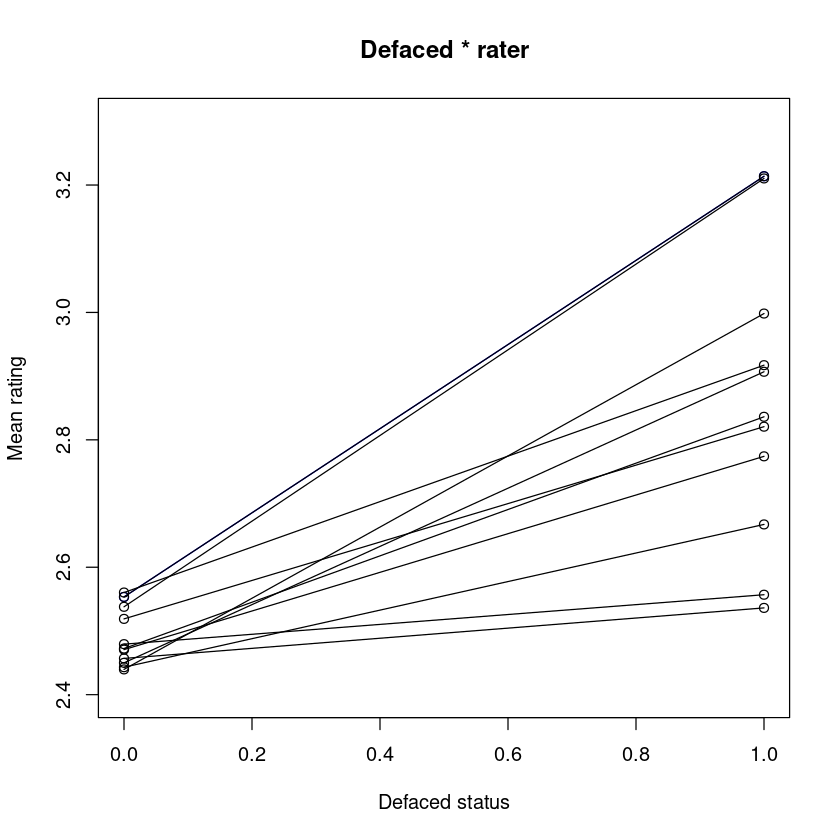

In [6]:
#Compute mean rating for each rater and each condition
mean_defaced = c()
mean_original = c()
for (i in 1:n_rater){
    df_small_defaced <- subset(df_full, defaced == 'defaced' & rater == sprintf('rater%02d', i))
    df_small_original <- subset(df_full, defaced == 'original' & rater == sprintf('rater%02d', i))
    mean_defaced[i] <- mean(as.numeric(df_small_defaced$ratings))
    mean_original[i] <- mean(as.numeric(df_small_original$ratings))
}

#Interaction plot
plot(c(0,1), c(mean_original[i], mean_defaced[i]),
    ylab="Mean rating",
    xlab="Defaced status",
    main ='Defaced * rater',
    ylim = c(2.4,3.3),
    type="o",
    col="blue")
for (i in 2:n_rater){ 
    lines(c(0,1), c(mean_original[i], mean_defaced[i]), type='o')
}

In the plot above, one line represents the evolution of the mean rating before and after defacing for one rater. The lines are not parallel, so we have to include the interaction term into the model. I interpret it as different raters are differently biased by the defacing process.
BUT we need to reduce the number of raters, because too many raters implies too many coefficients to estimate, hence the model doesn't converge.

### How to deal with missing values

List the different options available to deal with missing values.

In [7]:
getOption("na.action")

[1] "na.omit"

In [8]:
library(lme4)
fm1 <- lmer(as.numeric(ratings) ~ defaced + (1 | rater), data=df_missing, na.action=na.exclude)
summary(fm1)
ranef(fm1)

ERROR: Error: bad 'data': object 'df_missing' not found
